<a href="https://colab.research.google.com/github/pkant-0/IW/blob/main/K_Means_Clustering_of_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'iris-flower-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17860%2F23404%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T104702Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D03b6f8882a6bc2e89b32b046159e65d3af25102a6b815b44c731521233efb185c3ec23f8d03f8e849d15dd78fb0d16467cc648ebfd5a20bf35d91e582644a9d5bd1a59a453e3b2388006f1b1c8db0b5ff16e38b1f216852db9267f36b22dd5da9445588e2dd952d5c1c43b54b680934430f9466ce38312635f54cf7d56b3c2ef8ba0e44581b8ac71e6891f5a485cdbb9426d93f771ee3c572f084f925390ba3bdf763b919f1a1fe1b7c2eebb4647166cff4f1cd6435e4913cea9da88e87b07a50fa05b2e6a8882d3e1a634512a5613651442087618593afaca0b9a56d4d38bb6ee6e711f433f52dbc152d6a9dd6488586c498451ad2376d4a7badcfd0bb48a2c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician, eugenicist, and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis.[[1](https://en.wikipedia.org/wiki/Iris_flower_data_set#:~:text=The%20Iris%20flower%20data%20set,example%20of%20linear%20discriminant%20analysis.)] It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species.[2] Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".[3] Fisher's paper was published in the journal, the Annals of Eugenics, creating controversy about the continued use of the Iris dataset for teaching statistical techniques today.

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

![https://miro.medium.com/max/2550/0*GVjzZeYrir0R_6-X.png](https://miro.medium.com/max/2550/0*GVjzZeYrir0R_6-X.png)

source image:https://miro.medium.com/max/2550/0*GVjzZeYrir0R_6-X.png

This study we try to clustering Iris Dataset used Kmeans

[Attribute Information:
](https://archive.ics.uci.edu/ml/datasets/iris)
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
-- Iris Setosa
-- Iris Versicolour
-- Iris Virginica

import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

reading dataset

In [2]:
iris = pd.read_csv("/content/Iris.csv")
x = iris.iloc[:, [0, 1, 2, 3]].values



In [4]:
iris.info()
iris[0:15]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [5]:
#Frequency distribution of species"
iris_outcome = pd.crosstab(index=iris["Species"],  # Make a crosstab
                              columns="count")      # Name the count column

iris_outcome

col_0,count
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


In [6]:
iris_setosa=iris.loc[iris["Species"]=="Iris-setosa"]
iris_virginica=iris.loc[iris["Species"]=="Iris-virginica"]
iris_versicolor=iris.loc[iris["Species"]=="Iris-versicolor"]

**Distribution plots
**

plot each flower to a histogram

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packa

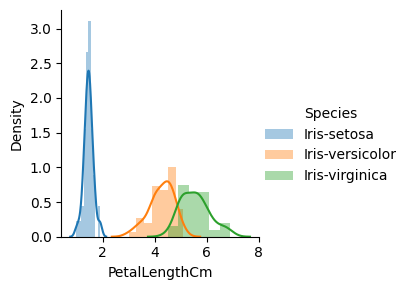

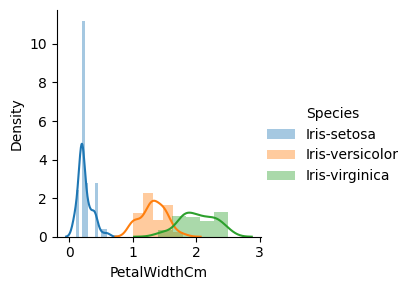

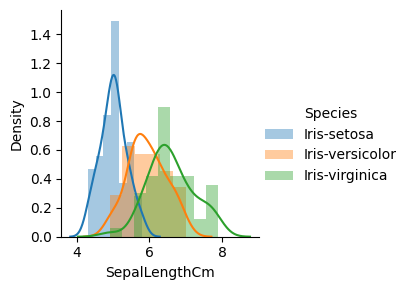

In [8]:
sns.FacetGrid(iris,hue="Species").map(sns.distplot,"PetalLengthCm").add_legend()
sns.FacetGrid(iris,hue="Species").map(sns.distplot,"PetalWidthCm").add_legend()
sns.FacetGrid(iris,hue="Species").map(sns.distplot,"SepalLengthCm").add_legend()
plt.show()

box plot

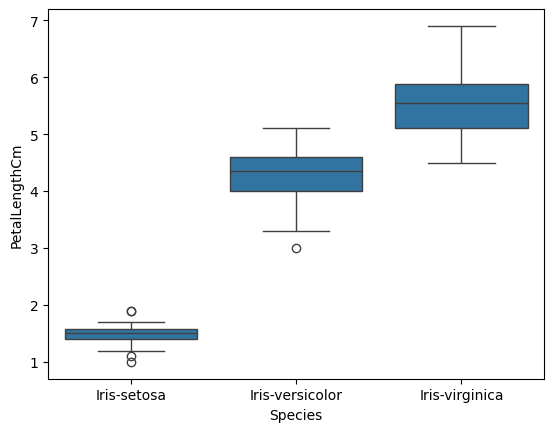

In [9]:
sns.boxplot(x="Species",y="PetalLengthCm",data=iris)
plt.show()

violin plot

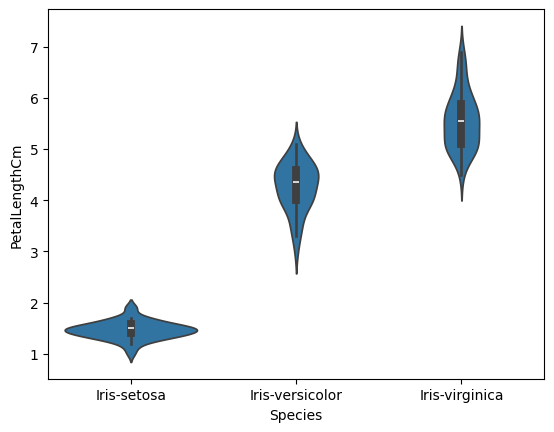

In [10]:
sns.violinplot(x="Species",y="PetalLengthCm",data=iris)
plt.show()

**Scatter plot**


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


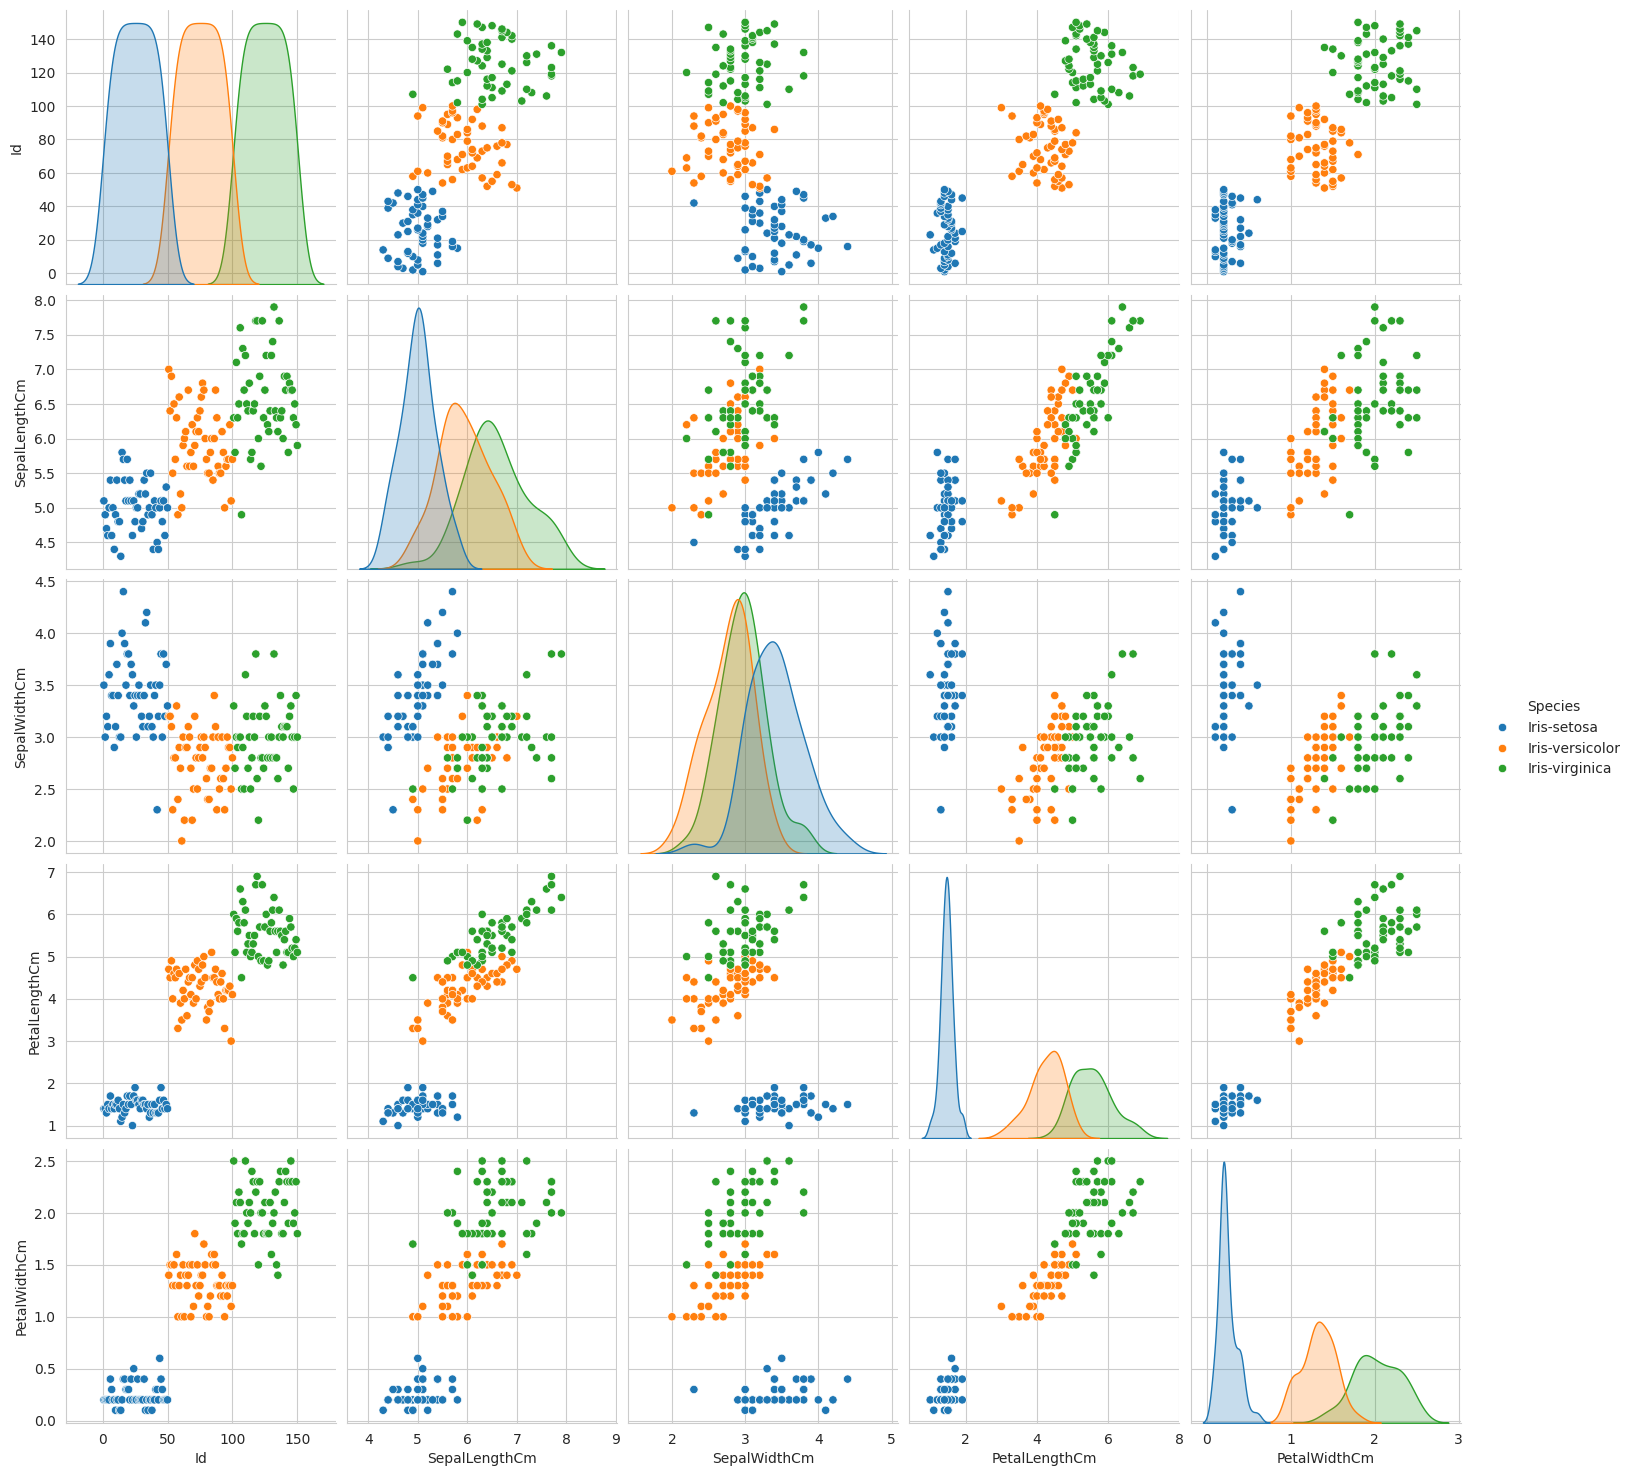

In [11]:
sns.set_style("whitegrid")
sns.pairplot(iris,hue="Species",size=3);
plt.show()

# K-Means

[K-means](http://https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/) is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

# How to Implementing K-Means Clustering ?

* Choose the number of clusters k
* Select k random points from the data as centroids
* Assign all the points to the closest cluster centroid
* Recompute the centroids of newly formed clusters
* Repeat steps 3 and 4


In [12]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

# Using the elbow method to determine the optimal number of clusters for k-means clustering


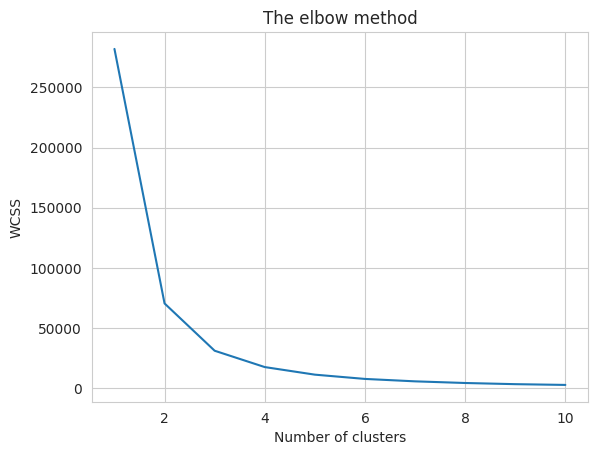

In [13]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

# Implementing K-Means Clustering

In [14]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)

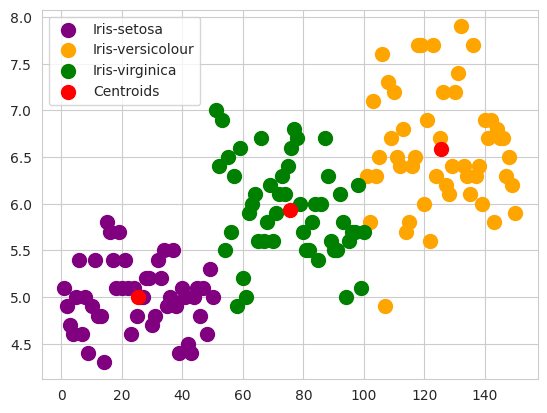

In [15]:
#Visualising the clusters
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')

plt.legend()

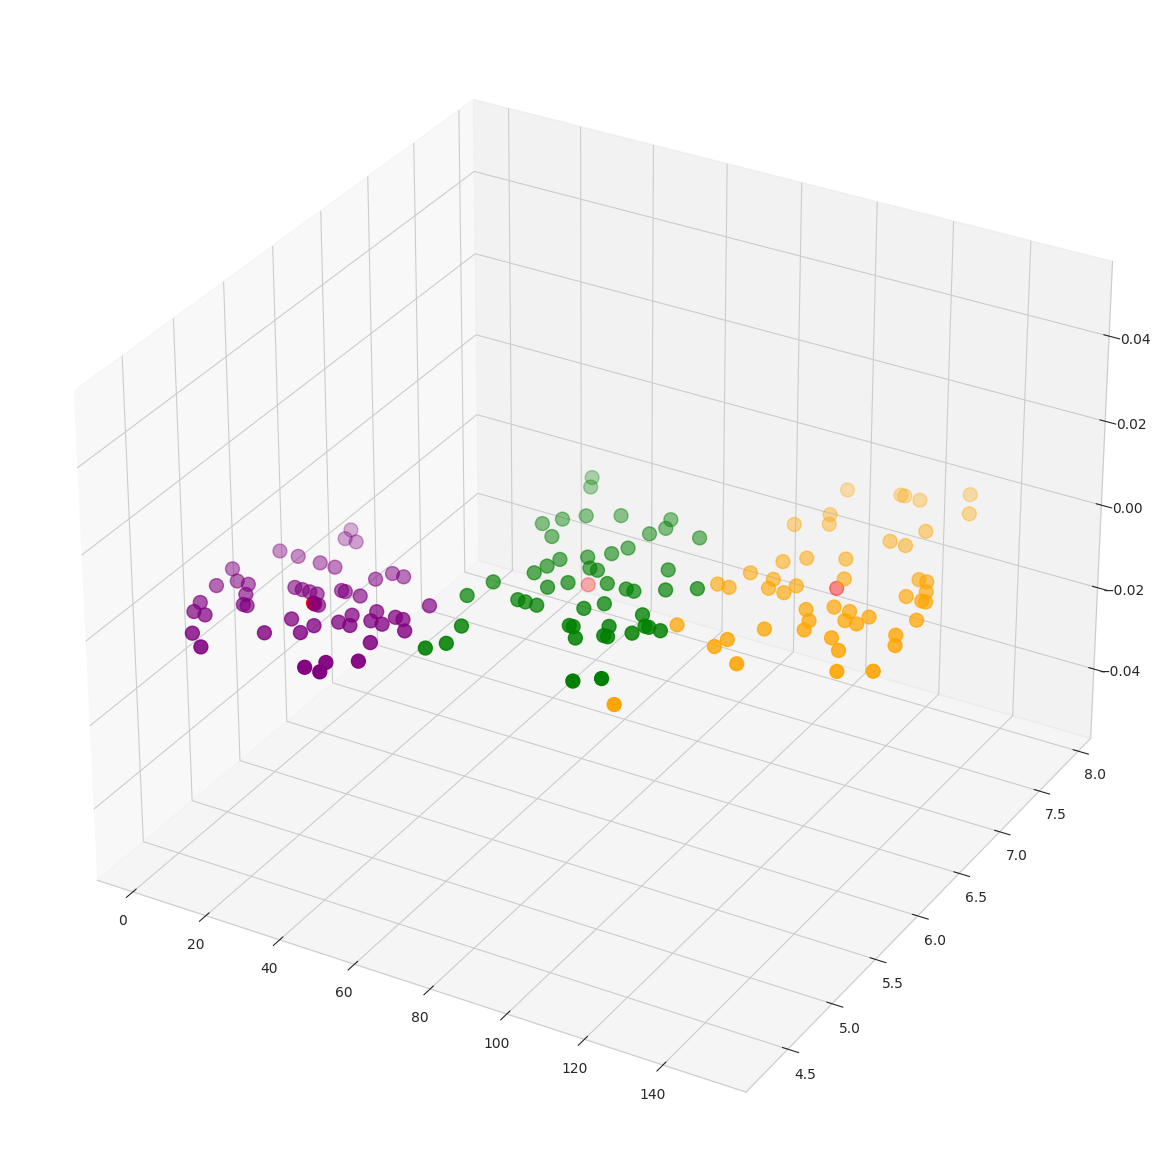

In [16]:
# 3d scatterplot using matplotlib

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'purple', label = 'Iris-setosa')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'orange', label = 'Iris-versicolour')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Iris-virginica')

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red', label = 'Centroids')
plt.show()